# 7 - Construindo um LLM do Zero: Treinando um Foundational Model

Este é o **sétimo** de uma série de oito artigos que podem ser encontrados no meu medium. Acesse o primeiro artigo da série aqui: [Construindo um LLM: entendendo os Grandes Modelos de Linguagem](https://blog.zfab.me/construindo-um-llm-entendendo-os-grandes-modelos-de-linguagem-b37884219eaa)

----
Com a arquitetura do nosso modelo concluída, alcançamos o primeiro objetivo desta série: construir um LLM do zero. No entanto, nosso modelo atual consiste apenas em matrizes aleatórias que produzem texto sem significado. Neste artigo, daremos um passo crucial: transformar esse modelo em uma ferramenta capaz de gerar texto (um pouco mais) coerente.

Para alcançar esse objetivo, precisamos treinar o modelo com um imenso volume de texto, ensinando-o a prever o próximo token com base nos anteriores. Este processo, conhecido como pré-treino, é o que nos entregará nosso Modelo Fundacional.

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.nn import functional as F
import sentencepiece as spm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12})

In [5]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self, d_in, d_out, context_length, n_heads, qkv_bias=False, dropout=0.1
    ):
        super().__init__()

        assert d_out % n_heads == 0, "d_out deve ser divisível por num_heads"

        self.d_out = d_out
        self.n_heads = n_heads
        self.d_head = d_out // n_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        n_batch, n_tokens, _ = x.size()

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(n_batch, n_tokens, self.n_heads, self.d_head)
        keys = keys.view(n_batch, n_tokens, self.n_heads, self.d_head)
        values = values.view(n_batch, n_tokens, self.n_heads, self.d_head)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1)
        attention_scores.masked_fill_(
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf
        )

        attention_weights = torch.softmax(
            attention_scores / keys.size(-1) ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)

        context_vector = (attention_weights @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(n_batch, n_tokens, self.d_out)
        context_vector = self.out_proj(context_vector)

        return context_vector

class LayerNorm(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.eps = 1e-6  # Epsilon para evitar divisão por zero
        self.scale = nn.Parameter(
            torch.ones(d_emb)
        )  # Gamma - Inicializando com 1 para não alterar a escala
        self.shift = nn.Parameter(
            torch.zeros(d_emb)
        )  # Beta - Inicializando com 0 para não alterar o deslocamento

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift  # Gamma * x_norm + Beta

class GeLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

class FeedForward(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(d_emb, d_emb * 4),
            GeLU(),
            nn.Linear(d_emb * 4, d_emb),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, d_emb, n_heads, context_length, dropout=0.1, qkv_bias=False):
        super().__init__()
        self.mha = MultiHeadAttention(
            d_in=d_emb,
            d_out=d_emb,
            context_length=context_length,
            n_heads=n_heads,
            dropout=dropout,
            qkv_bias=qkv_bias,
        )
        self.ff = FeedForward(d_emb)
        self.norm1 = LayerNorm(d_emb)
        self.norm2 = LayerNorm(d_emb)
        self.drop_shortcut = nn.Dropout(dropout)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)  # 1
        x = self.mha(x)  # 2
        x = self.drop_shortcut(x)  # 3
        x = x + shortcut  # 4

        shortcut = x
        x = self.norm2(x)  # 5
        x = self.ff(x)  # 6
        x = self.drop_shortcut(x)  # 7
        x = x + shortcut  # 8
        return x

class GPTModel(nn.Module):
    def __init__(
        self, d_vocab, d_emb, context_length, n_layers, n_heads, dropout, qkv_bias
    ):
        super().__init__()
        self.context_length = context_length

        # Embedding de tokens e de posição
        self.tok_emb = nn.Embedding(d_vocab, d_emb)
        self.pos_emb = nn.Embedding(context_length, d_emb)
        self.drop_emb = nn.Dropout(dropout)

        # Sequência de Blocos Transformers
        self.trf_blocks = nn.Sequential(
            *[
                TransformerBlock(d_emb, n_heads, context_length, dropout, qkv_bias)
                for _ in range(n_layers)
            ]
        )

        # Normalização e projeção para o vocabulário
        self.final_norm = LayerNorm(d_emb)
        self.out_head = nn.Linear(d_emb, d_vocab, bias=False)

        # Inicialização dos pesos
        self.apply(self._init_weights)

        # Weight tying
        self.out_head.weight = self.tok_emb.weight

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # Embedding de tokens e de posição
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        # Sequência de Blocos Transformers
        x = self.trf_blocks(x)

        # Normalização e projeção para o vocabulário
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

    # Função para gerar texto
    def generate(self, input, max=200, temperature=1.0, top_k=0, top_p=1.0):
        for _ in tqdm(range(max), desc="Gerando Tokens..."):
            input = input[
                :, -self.context_length :
            ]  # Garantindo que o seja no máximo do tamanho do contexto.
            logits = self(input)
            logits = logits[:, -1, :]

            # Aplicando temperature
            logits = logits / temperature

            # Aplicando top_k se especificado
            if top_k > 0:
                top_k_values, top_k_indices = torch.topk(
                    logits, min(top_k, logits.size(-1))
                )
                logits = torch.full_like(logits, float("-inf"))
                logits.scatter_(1, top_k_indices, top_k_values)

            # Aplicando top_p (nucleus sampling) se menor que 1.0
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    F.softmax(sorted_logits, dim=-1), dim=-1
                )

                # Remove tokens com probabilidade cumulativa acima do threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift para manter pelo menos um token
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[..., indices_to_remove] = float("-inf")

            # Convertendo para probabilidades e amostrando
            prob = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(prob, num_samples=1)
            input = torch.cat([input, next_token], dim=-1)

            if next_token == 3:  # Token de fim de texto
                break

        return input
    
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

@torch.no_grad()
def generate_sample(model, device, tokenizer, input_text, max_token=200, temperature=1, top_k=0, top_p=1):
    input_tokens = torch.tensor(tokenizer.encode(input_text), dtype=torch.long)
    input_tokens = input_tokens.unsqueeze(0).to(device)

    output = model.generate(input_tokens, max_token, temperature, top_k, top_p)
    output_text = tokenizer.decode(output.squeeze().tolist())

    return output_text

# Modelos Fundacionais

Um Modelo Fundacional (Foundational Model) é um LLM pré-treinado em uma vasta quantidade de dados não rotulados — no nosso caso, textos de diversas origens. São chamados “fundacionais” porque estabelecem uma base de conhecimento que pode ser adaptada para múltiplos propósitos.

Os modelos opensource, como os que encontramos no HuggingFace, eles são identificados com sufixos como “-base” ou “-pt” (pré-treinado). Por exemplo, “bert-base” ou “gemma3–4b-pt” indicam versões fundacionais que passaram apenas pela fase de pré-treino, sem especialização para tarefas específicas.

Por si só, esses modelos pré-treinados são excelentes completadores de frases: dados os tokens anteriores, eles preveem o próximo e, ao realizar esse processo recursivamente, geram conteúdo.

Uma descoberta interessante foi a capacidade desses modelos de realizar tarefas sem treino específico, conhecido como “**zero-shot learning**”. Pesquisadores observaram que modelos pré-treinados em grandes volumes de texto conseguiam responder perguntas, classificar textos e até resolver problemas simples de raciocínio sem nunca terem sido explicitamente treinados para isso.

Esse fenômeno sugere que o processo de pré-treino não apenas ensina o modelo a prever palavras, mas também permite que ele desenvolva uma compreensão mais profunda da linguagem e do conhecimento contido nos textos. No entanto, o desempenho zero-shot geralmente é inferior ao de modelos especializados, justificando a necessidade de fine-tuning para tarefas específicas como conversação ou classificação de texto.

# Processo de Treinamento

Vamos começar instanciando nosso modelo e gerando alguns textos para avaliarmos após o pré treinamento seu desempenho.

Vamos instanciar nosso tokenizer, que criamos no segundo artigo da série, e o `GPTModel` que finalizamos no artigo passado

In [6]:
# Carregando o Tokenizer e o Modelo
tk = spm.SentencePieceProcessor(
    model_file="../models/gigaverbo_tk.model"
)

MODEL = GPTModel(
    d_vocab=tk.vocab_size(),
    d_emb=768,
    context_length=256,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=True,
)

total_params = sum(p.numel() for p in MODEL.parameters())
print(f"Total de parâmetros: {total_params:,}")

# OUTPUT
# Total de parâmetros: 88,398,336

Total de parâmetros: 88,398,336


Nosso objetivo não é criar uma nova família de modelos ou competir com as Big Techs, por isso nosso modelo será pequeno — muito pequeno: apenas **88M de parâmetros**. Para colocar em perspectiva, hoje em dia até os modelos considerados pequenos têm alguns **bilhões de parâmetros**.

Como nosso foco é entender o funcionamento dos LLMs, desde sua arquitetura até seu treinamento, não precisamos gastar processamento com um modelo gigante. O que diferencia nosso modelo dos demais será basicamente seu tamanho, a quantidade de tokens processados no pré-treinamento e, consequentemente, o tempo de treinamento.

Se você tiver uma GPU disponível e quiser treinar um modelo maior, poderá usar o mesmo código — basta ajustar parâmetros como janela de contexto, número de blocos transformers e tamanho dos embeddings.

Por enquanto, para nosso objetivo de aprendizado, esse modelinho será mais que suficiente.

In [7]:
responses = []
for i in range(5):
    response = generate_sample(
        model=MODEL, 
        device="cpu", 
        tokenizer=tk, 
        input_text="O Brasil é um", 
        max_token=30, 
        temperature=0.4,
        top_k=40,
        top_p=0.9
    )
    responses.append(response)
print("")
for i, response in enumerate(responses):
    print(f"Resposta {i+1}: {response}")

#OUTPUT
# Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 15.56it/s]
# Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 17.86it/s]
# Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 18.20it/s]
# Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 17.56it/s]
# Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 21.82it/s]
#
# Resposta 1: O Brasil é umiros alterna frase Terposição maneirasró ide ganiros� benefíciosbilidades bas baix tele baixaérciobilidades necessidade acab específicasab espera negócios� fecoocê
# Resposta 2: O Brasil é um descont Eleeio fe relexto programater.bilidades legumes resumociar sequin bollialia noviros baixa eventos muitoodos tradicionalhhe sequ tentume
# Resposta 3: O Brasil é umbilidades minha mund x fraseá mó medoientocê minhatório programa situocê mon Pateretes vi espa profissionalard Googleale notícias nov baixaocê
# Resposta 4: O Brasil é ummicas interaçãoando especial" candida Reitos prática Sim passos na tarocêritân emissões partetional amigo Falvamalidade tradicional parte benefícios usar iP muito facil facil
# Resposta 5: O Brasil é um candidats saudável perguntasYáticas negócios frutas tele Ol descont capacidadearami cai� tele emp usadasumeing Ro lamico escolhabilidades negóciosbilidades segundo

Gerando Tokens...: 100%|██████████| 30/30 [00:02<00:00, 13.42it/s]


Resposta 1: O Brasil é umcho ó estiver veíançasTu Geren clima Mo ó estabel Colhoumou� poderiacu confiais porporte entrada tur[stitumanha ent
Resposta 2: O Brasil é umussãochouas chamadaram capvenção atual dicas veí existemst frequentementehou venchocho veí veíanotação diferentehou Apple Alguns jorn prov sites combussão
Resposta 3: O Brasil é um prov dim cap metas pol Com paiselo af comb maiorementwnica sono fazendoohpidamenteíqu essencial Apple identicaicapres dada existem sono grav
Resposta 4: O Brasil é um poleloenef Austeloícileleza Ol financeiros Apple conexug Austcho mercado dor filmebora alternastitusarb met ing ele alternatur[ Califórnia us
Resposta 5: O Brasil é umCrie produzeral po víde M empresastur Eu Apple ingonesongão estiver especial melhor mem�� natural empresaicamente específica resul ent gencho


Como podemos observar, nosso modelo atual é apenas um gerador de palavras sem sentido. Ao fornecer a entrada "O Brasil é um", ele gera frases completamente aleatórias. Nosso objetivo é que, após o pré-treinamento, o modelo seja capaz de construir frases mais coerentes.

## Preparando o Dataset

A preparação adequada dos dados é um elemento crítico no treinamento de modelos de linguagem. O processo envolve fornecer tokens de entrada ao modelo para que ele aprenda a prever o próximo token da sequência.

Para isso, precisamos estruturar nosso dataset de maneira específica, permitindo que o modelo desenvolva a capacidade de fazer previsões contextualizadas.

In [8]:
phrase = "O Brasil é um país muito bonito <|eos|>"
words = phrase.split()

context_window = 3

for i in range(len(words)-context_window):
    print("Iteração", i+1)
    print(f"Input:\t{words[i:i+context_window]}")
    print(f"Output:\t{words[i+1:i+context_window+1]}")
    print("---")

#OUTPUT
# Iteração 1
# Input:	['O', 'Brasil', 'é']
# Output:	['Brasil', 'é', 'um']
# ---
# Iteração 2
# Input:	['Brasil', 'é', 'um']
# Output:	['é', 'um', 'país']
# ---
# Iteração 3
# Input:	['é', 'um', 'país']
# Output:	['um', 'país', 'muito']
# ---
# Iteração 4
# Input:	['um', 'país', 'muito']
# Output:	['país', 'muito', 'bonito']
# ---
# Iteração 5
# Input:	['país', 'muito', 'bonito']
# Output:	['muito', 'bonito', '<|eos|>']
# ---

Iteração 1
Input:	['O', 'Brasil', 'é']
Output:	['Brasil', 'é', 'um']
---
Iteração 2
Input:	['Brasil', 'é', 'um']
Output:	['é', 'um', 'país']
---
Iteração 3
Input:	['é', 'um', 'país']
Output:	['um', 'país', 'muito']
---
Iteração 4
Input:	['um', 'país', 'muito']
Output:	['país', 'muito', 'bonito']
---
Iteração 5
Input:	['país', 'muito', 'bonito']
Output:	['muito', 'bonito', '<|eos|>']
---


No exemplo acima, usando uma janela de contexto de 3 tokens e a frase `O Brasil é um país muito bonito <|eos|>` como dado de treinamento, precisamos estruturar o dataset para ter 3 tokens de entrada, com a saída sendo os mesmos 3 tokens deslocados uma posição para a direita.

Por exemplo, quando usamos como input o início `O Brasil é`, o output correspondente será `Brasil é um` , assim o modelo aprenderá a prever qual token deve vir após certas palavras, dado certos contextos.

Na hora de preparar o dataset, além da janela de contexto, para podermos “separar” os inputs, outra informação importante é o que chamamos de stride, que determina o tamanho do "passo" entre as janelas de contexto consecutivas.

Um stride menor cria mais sobreposição entre as janelas, gerando mais dados de treinamento, enquanto um stride maior reduz a sobreposição e economiza memória. A escolha do stride ideal é um trade-off entre volume de dados e eficiência computacional.

In [9]:
phrase = "O Brasil é um país muito bonito <|eos|>"
words = phrase.split()

context_window = 3
stride = 2

for i in range(0, len(words)-context_window, stride):
    print("Iteração", (i//stride)+1)
    print(f"Input:\t{words[i:i+context_window]}")
    print(f"Output:\t{words[i+1:i+context_window+1]}")
    print("---")

#OUTPUT
# Iteração 1
# Input:	['O', 'Brasil', 'é']
# Output:	['Brasil', 'é', 'um']
# ---
# Iteração 2
# Input:	['é', 'um', 'país']
# Output:	['um', 'país', 'muito']
# ---
# Iteração 3
# Input:	['país', 'muito', 'bonito']
# Output:	['muito', 'bonito', '<|eos|>']
# ---

Iteração 1
Input:	['O', 'Brasil', 'é']
Output:	['Brasil', 'é', 'um']
---
Iteração 2
Input:	['é', 'um', 'país']
Output:	['um', 'país', 'muito']
---
Iteração 3
Input:	['país', 'muito', 'bonito']
Output:	['muito', 'bonito', '<|eos|>']
---


Ao adicionar o stride ao nosso exemplo, vemos que entre as iterações estamos pulando 2 palavras (em vez de uma). Por exemplo, se na primeira janela pegamos `O Brasil é`, na próxima pegaremos `é um país`, pulando `O` e `Brasil`.

Com stride igual a 2, obtivemos apenas 3 conjuntos de inputs com a frase, em comparação aos 5 conjuntos obtidos sem stride (ou com stride igual a 1).

Para nosso treinamento, precisaremos de mais conteúdo que apenas uma frase. Por isso, criaremos o dataset com o mesmo corpus usado para gerar o tokenizer: uma parte do dataset **GigaVerbo**. Nosso corpus contém aproximadamente 25 milhões de tokens.

In [10]:
with open("../data/gigaverbo_tokenized.txt", "r", encoding="utf-8") as f:
    text_tokenized = f.read()

num_tokens = len(text_tokenized.split())
print(f"Número de tokens no corpus: {num_tokens:,}")

#OUTPUT
# Número de tokens no corpus: 24,982,439

Número de tokens no corpus: 24,982,439


Além de organizar os tokens do nosso corpus nesse formato de input e output, precisamos também agrupar os inputs e seus respectivos outputs esperados (que chamaremos de targets) em conjuntos chamados batches, para otimizar o processo de treinamento.

Um batch reúne múltiplos exemplos para processamento simultâneo pelo modelo, tornando o treinamento mais eficiente.

In [11]:
phrase = "O Brasil é um país da América do Sul <|eos|>"
words = phrase.split()

context_window = 3
stride = 2
batch_size = 2  # Number of examples per batch

inputs = []
targets = []

for i in range(0, len(words)-context_window, stride):
    inputs.append(words[i:i+context_window])
    targets.append(words[i+1:i+context_window+1])

# Reshape the list to batch_size x num_examples x num_words
inputs = np.array(inputs).reshape(batch_size, -1, 3)
targets = np.array(targets).reshape(batch_size, -1, 3)

print(f"Shape (Batch x Trecho x Tokens): {inputs.shape}\n")
for i in range(batch_size):
    print(f"Batch {i+1}")
    print(f"Input:\n{inputs[i]}")
    print(f"Target:\n{targets[i]}")
    print("---")

#OUTPUT
# Shape (Batch x Trecho x Tokens): (2, 2, 3)
# 
# Batch 1
# Input:
# [['O' 'Brasil' 'é']
#  ['é' 'um' 'país']]
# Target:
# [['Brasil' 'é' 'um']
#  ['um' 'país' 'da']]
# ---
# Batch 2
# Input:
# [['país' 'da' 'América']
#  ['América' 'do' 'Sul']]
# Target:
# [['da' 'América' 'do']
#  ['do' 'Sul' '<|eos|>']]
# ---

Shape (Batch x Trecho x Tokens): (2, 2, 3)

Batch 1
Input:
[['O' 'Brasil' 'é']
 ['é' 'um' 'país']]
Target:
[['Brasil' 'é' 'um']
 ['um' 'país' 'da']]
---
Batch 2
Input:
[['país' 'da' 'América']
 ['América' 'do' 'Sul']]
Target:
[['da' 'América' 'do']
 ['do' 'Sul' '<|eos|>']]
---


Para fazer todo esse processamento, usaremos duas classes da biblioteca PyTorch que facilitam a estruturação e o gerenciamento dos inputs e targets usados no treinamento.

Criaremos uma classe que herda de Dataset para representar nossos dados, enquanto usaremos o DataLoader para gerenciar o carregamento e a distribuição dos dados durante o treinamento.

In [12]:
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(
    txt,
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0,
):
    dataset = GPTDataset(txt, tk, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )

    return dataloader

Reparem que nossa classe Dataset está separando o conteúdo passado (`txt`) em inputs e targets usando a mesma lógica que vimos anteriormente. Além disso precisamos implementar a função `__len__` e `__getitem__` que são métodos especiais do Python necessários para que nossa classe funcione corretamente com o DataLoader. O método **len** retorna o tamanho total do dataset, enquanto **getitem** permite acessar um elemento específico através de seu índice.

A função que `create_dataloader` que criamos serve para criar o Dataset e passa-lo para um DataLoader que cuidará de gerenciar e separar nossos batchs. Ao criar o Dataloader estamos definindo alguns parametros para configurar como nossos dados serão gerenciados e disponibilizados para o modelo:

- `batch_size` : Quantas “frases” teremos dentro de cada batch
- `shuffle` : Controla se os dados serão embaralhados aleatoriamente durante o treinamento
- `drop_last` : Define se o último batch será descartado caso seja menor que o tamanho definido
- `num_workers` : Número de processos paralelos para carregamento dos dados
- `pin_memory` : Define se os tensores serão alocados em uma região de memória específica da CPU que permite transferência mais rápida para a GPU

Vamos testar e ver se a classe e a função estão funcionando corretamente

In [13]:
phrase = "O Brasil é um país da América do Sul <|eos|>"
dataloader = create_dataloader(phrase, batch_size=2, max_length=3, stride=2)

for i, (input_ids, target_ids) in enumerate(dataloader):
    print(f"Batch {i+1}")
    print(f"Input:\n{input_ids}")
    print(f"Target:\n{target_ids}")
    print("---")

#OUTPUT
# Batch 1
# Input:
# tensor([[ 355,  474,  385],
#         [ 323,  313, 1040]])
# Target:
# tensor([[ 474,  385,  363],
#         [ 313, 1040,  334]])
# ---
# Batch 2
# Input:
# tensor([[1040,  334, 3268],
#         [ 385,  363,  323]])
# Target:
# tensor([[ 334, 3268,  320],
#         [ 363,  323,  313]])
# ---

Batch 1
Input:
tensor([[ 355,  474,  385],
        [3268,  320, 3254]])
Target:
tensor([[ 474,  385,  363],
        [ 320, 3254, 4021]])
---
Batch 2
Input:
tensor([[1040,  334, 3268],
        [ 323,  313, 1040]])
Target:
tensor([[ 334, 3268,  320],
        [ 313, 1040,  334]])
---


Observe que obtivemos a mesma estrutura do nosso exemplo manual, mas agora com números (os IDs dos tokens) no lugar das palavras.

Como em todo processo de treinamento vamos separar uma parte do nosso corpus para validação e manter o restante para treinamento

In [14]:
with open("../data/gigaverbo.txt", "r", encoding="utf-8") as f:
    text = f.read()

train_ratio = 0.9
split_idx = int(len(text) * train_ratio)

train_data = text[:split_idx]
val_data = text[split_idx:]

Após separar, vamos criar nossos Dataloader, um para treino e outro para validação

In [ ]:
train_dataloader = create_dataloader(
    train_data,
    batch_size=8,
    max_length=256,
    stride=128,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_dataloader = create_dataloader(
    val_data,
    batch_size=8,
    max_length=256,
    stride=128,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

NameError: name 'create_dataloader' is not defined

KeyboardInterrupt: 

Estas configurações e tamanhos de batch são apenas exemplos ilustrativos. As configurações reais utilizadas no treinamento podem ser encontradas no arquivo de treino no github do projeto. 

In [93]:
def get_tensor_size(tensor):
    return tensor.element_size() * tensor.nelement()

def get_dataset_tensor_memory(dataset):
    input_size = sum(get_tensor_size(tensor) for tensor in dataset.input_ids)
    target_size = sum(get_tensor_size(tensor) for tensor in dataset.target_ids)
    return input_size + target_size

tensor_mem = get_dataset_tensor_memory(train_dataloader.dataset)
print(f"Memória ocupada pelo dataset de Treino: {tensor_mem/1024/1024:.2f} MB")

tensor_mem = get_dataset_tensor_memory(val_dataloader.dataset)
print(f"Memória ocupada pelo dataset de Validação: {tensor_mem/1024/1024:.2f} MB")

#OUTPUT
# Memória ocupada pelo dataset de Treino: 678.52 MB
# Memória ocupada pelo dataset de Validação: 83.88 MB

Memória ocupada pelo dataset de Treino: 678.52 MB
Memória ocupada pelo dataset de Validação: 83.88 MB


Analisando o consumo de memória inicial, nosso dataset ocupa aproximadamente 760 MB. Quando adicionamos o modelo, que utiliza cerca de 300 MB, chegamos a um total de 1 GB de memória dedicada apenas ao armazenamento dos tensores. Durante o treinamento, esse consumo aumenta significativamente devido à necessidade de armazenar gradientes, estados do otimizador, caches de atenção e outras estruturas temporárias.

Isso evidencia que um dos principais desafios no treinamento de modelos de linguagem não se limita apenas ao poder de processamento, mas também à gestão eficiente da memória disponível.

Para nosso modelo relativamente pequeno e dataset reduzido, manter todos os dados na memória RAM é viável. No entanto, em cenários de treinamento de modelos maiores com datasets gigantescos, este se torna um dos principais gargalos.

Agora que o DataLoader está configurado, podemos passar para o treinamento. Antes, porém, vamos entender como avaliar o desempenho do modelo durante esse processo para ajustar corretamente seus pesos e bias.

## A Função de Perda

No centro de todo treinamento de modelos está a função de perda (Loss Function), que mede quanto as previsões do modelo se desviam dos valores reais para então ajustar os parâmetros com o objetivo de diminuir progressivamente o erro. No nosso caso, a função de perda indica o quanto o modelo está distante de prever corretamente o próximo token.

Existem várias formas de calcular esse valor de perda. Para o tipo de problema que estamos abordando — que é essencialmente um problema de classificação multiclasse — a mais comum é a Cross-Entropy.

A Cross-Entropy (Entropia Cruzada) é uma medida da diferença entre duas distribuições de probabilidade: a distribuição prevista pelo modelo e a distribuição real dos dados. Em termos matemáticos, para um problema de classificação com (C) classes, a cross-entropy é definida como:

$$
H(y, \hat{y}) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Onde:

•	$y_i$ é a probabilidade real (geralmente 0 ou 1 em classificação)

•	$\hat{y}_i$ é a probabilidade prevista pelo modelo

Para entendermos como a Cross-Entropy funciona na prática, vamos analisar um exemplo:

In [94]:
phrase = "O gato que gostava de andar de bicicleta"
dataloader = create_dataloader(phrase, batch_size=2, max_length=3, stride=2)

first_batch = next(iter(dataloader))

print(f"Input shape: {first_batch[0].shape}")
print(first_batch[0])
print("---")
print(f"Target shape: {first_batch[1].shape}")
print(first_batch[1])

#OUTPUT
# Input shape: torch.Size([2, 3])
# tensor([[ 355, 3757,  302],
#         [ 306,  364,  269]])
# ---
# Target shape: torch.Size([2, 3])
# tensor([[3757,  302, 1680],
#         [ 364,  269, 2169]])

Input shape: torch.Size([2, 3])
tensor([[ 302, 1680,  306],
        [ 306,  364,  269]])
---
Target shape: torch.Size([2, 3])
tensor([[1680,  306,  364],
        [ 364,  269, 2169]])


Neste exemplo, temos duas sequências de entrada e seus respectivos alvos (targets), que são as sequências deslocadas em uma posição. Vamos passar os inputs para o modelo e verificar o que ele está prevendo

In [95]:
with torch.no_grad():
    logits = MODEL(first_batch[0])

probas = torch.softmax(logits, dim=-1)
probas.shape

#OUTPUT
# torch.Size([2, 3, 4096])

torch.Size([2, 3, 4096])

Como vimos no artigo anterior, nosso modelo retorna um tensor que contém, para cada token em cada frase, a probabilidade de cada um dos 4.096 tokens do vocabulário ser a próxima palavra. Vamos pegar o ID do token com maior probabilidade

In [96]:
tokens_id = torch.argmax(probas, dim=-1)
print(f"Output previsto (y_hat):\n{tokens_id.numpy()}")

#OUTPUT
# Output previsto (y_hat):
# [[1452  223 3121]
#  [3119  722  651]]

Output previsto (y_hat):
[[3857 2090  996]
 [ 834 2273 1656]]


Este é o output que nosso modelo está gerando. Por exemplo, para o trecho O gato que, que foi convertido para os tokens de IDs 355, 3757 e 302, e usado como primeira entrada, o modelo previu que o próximo token seria  lo (último token do primeiro tensor de output, com ID 3121). 

In [97]:
phrase_target = tk.decode(first_batch[1][0].numpy().reshape(-1).tolist())
phrase_hat = tk.decode(tokens_id[0].numpy().reshape(-1).tolist())

print(f"Target (y):\n{phrase_target} ({first_batch[1][0]})")
print(f"Predicted (y_hat):\n{phrase_hat} ({tokens_id[0]})")

#OUTPUT
# Target (y):
# gato que gos (tensor([3757,  302, 1680]))
# Predicted (y_hat):
# lo� nossas (tensor([1452,  223, 3121]))

Target (y):
gostava (tensor([1680,  306,  364]))
Predicted (y_hat):
her prepara Est (tensor([3857, 2090,  996]))


Ao observar nosso target, ou seja, a resposta esperada, o próximo token deveria ser `gos` (representado pelo ID 1680). Como imaginamos, nosso modelo errou bastante. Mas como podemos quantificar esse “bastante”? É aí que entra a função de perda.

Para cada token de entrada, nosso modelo calcula a probabilidade de cada um dos 4096 tokens possíveis do nosso vocabulário. Como o modelo ainda não foi treinado, ele distribui as probabilidades de forma uniforme, resultando em aproximadamente 1/4096 de chance para cada token.

Podemos ver as probabilidades dos tokens

In [98]:
proba_tokens_output = probas[0, [0, 1, 2], tokens_id[0]]
proba_tokens_target = probas[0, [0, 1, 2], first_batch[1][0]]

print(f"Probabilidades para os tokens previstos:\n{proba_tokens_output}")
print(f"Probabilidades para os tokens alvo:\n{proba_tokens_target}")

#OUTPUT
# Probabilidades para os tokens previstos:
# tensor([0.0015, 0.0017, 0.0016])
# Probabilidades para os tokens alvo:
# tensor([0.0002, 0.0003, 0.0002])

Probabilidades para os tokens previstos:
tensor([0.0013, 0.0016, 0.0015])
Probabilidades para os tokens alvo:
tensor([1.5071e-04, 9.9407e-05, 6.5372e-04])


Nosso objetivo é maximizar a probabilidade dos tokens do target (no exemplo acima ficaram próximos de 0,0002) e minimizar a dos tokens restantes. Assim, o modelo aprenderá a prever corretamente o output.

In [99]:
cross_entropy = torch.log(proba_tokens_target) * -1
avg_log_proba = torch.mean(cross_entropy)
avg_log_proba

#OUTPUT
# tensor(8.4868)

tensor(8.4498)

O código acima implementa a fórmula de Cross-Entropy que vimos anteriormente, mas com algumas otimizações importantes:

O output do modelo é um vetor que contém as probabilidades para cada um dos 4.096 tokens do vocabulário. O target também precisa ser representado como um vetor de probabilidades. Como sabemos qual é o token correto, esse vetor se torna um one-hot encoding - com valor 1 na posição do token esperado e 0 nas demais posições.

Esta representação torna nosso cálculo mais simples: como a multiplicação por zero elimina a maioria dos termos da soma, precisamos calcular apenas o logaritmo da probabilidade do token alvo. Embora matematicamente equivalente à fórmula original da Cross-Entropy, esta abordagem é computacionalmente mais eficiente.

Como nossa sequência possui 3 tokens no output, calculamos a média das perdas individuais para obter uma única medida de perda para todo o input.

Em nosso código usaremos a função `cross_entropy` da biblioteca Pytorch já que oferece otimizações integradas e nos poupa de implementar esse cálculo manualmente

In [100]:
loss = torch.nn.functional.cross_entropy(logits[0], first_batch[1][0])
loss

#OUTPUT
# tensor(8.4868)

tensor(8.4498)

Para facilitar o cálculo e uso dessa informação durante o treinamento, vamos criar duas funções. A primeira, chamada `loss_batch`, calculará a perda para todo o conjunto quando receber um batch (conjunto de inputs e targets).

A segunda função, `loss_loader`, terá foco no Dataloader completo, onde especificamos um dataloader e a quantidade de batches para calcular a perda. Isso nos permite fazer uma avaliação mais abrangente do comportamento do modelo. Por exemplo, podemos calcular a perda média em um conjunto de validação para monitorar se o modelo está melhorando sua capacidade de generalização durante o treinamento.

In [101]:
def loss_batch(input_batch, target_batch, model, device):
    was_training = model.training
    model.eval()

    input_batch, target_batch = input_batch.to(device, non_blocking=True), target_batch.to(device, non_blocking=True)

    logits = model(input_batch)
    logits_flat = logits.flatten(0, 1)
    target_flat = target_batch.flatten()

    if was_training:
        model.train()

    return torch.nn.functional.cross_entropy(logits_flat, target_flat)

def loss_loader(data_loader, model, device, num_batchs = None):
    total_loss = 0.

    # Verifica se o dataloader está vazio
    if len(data_loader) == 0:
        return float("nan")
    # Se num_batchs for None, calcula a loss para todos os batchs
    elif num_batchs is None:
        num_batchs = len(data_loader)
    # Se num_batchs for maior que o tamanho do dataloader, calcula a loss para todos os batchs do data loader
    else:
        num_batchs = min(num_batchs, len(data_loader))

    for i, (x, y) in enumerate(data_loader):
        if i < num_batchs:
            loss = loss_batch(x, y, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batchs

loss_batch_result = loss_batch(first_batch[0], first_batch[1], MODEL, "cpu")
print(f"Loss do primeiro batch: {loss_batch_result:.4f}")

loss_loader_result = loss_loader(dataloader, MODEL, "cpu")
print(f"Loss do dataloader de exemplo: {loss_loader_result:.4f}")

#OUTPUT
# Loss do primeiro batch: 8.3901
# Loss do dataloader de exemplo: 8.5045

Loss do primeiro batch: 8.2431
Loss do dataloader de exemplo: 8.3253


É importante notar que os valores de Loss são diferentes porque calculamos primeiro para um único exemplo do batch, depois para o primeiro batch completo e, por fim, para todos os batches do dataloader.

In [102]:
MODEL.to(get_device())

loss_loader_train = loss_loader(train_dataloader, MODEL, get_device(), 10)
print(f"Loss Dataset de Treino: {loss_loader_train:.4f}")

loss_loader_val = loss_loader(val_dataloader, MODEL, get_device(), 10)
print(f"Loss Dataset de Validação: {loss_loader_val:.4f}")

#OUTPUT
# Loss Dataset de Treino: 8.5007
# Loss Dataset de Validação: 8.5155

Loss Dataset de Treino: 8.4546


KeyboardInterrupt: 

Podemos ver que a loss, calculada com alguns batches dos datasets de Treino e Validação, está alta. Nosso objetivo com o treinamento será diminuí-la

### Perplexidade

A perplexidade é uma métrica fundamental na avaliação de modelos de linguagem e vale entendermos um pouco sobre ela. Matematicamente, é expressa como o exponencial da cross-entropy:

$$
Perplexidade = e^{H(y, \hat{y})}
$$

Quanto menor a perplexidade, melhor o desempenho do modelo. Em termos práticos, a perplexidade pode ser interpretada como o número médio de escolhas prováveis que o modelo considera ao fazer uma previsão.

- **Perplexidade = 1:** Representa um modelo perfeito, que prevê com 100% de certeza cada token correto.
- **Perplexidade = 4:** Sugere que o modelo está, em média, "escolhendo" entre 4 opções igualmente prováveis para cada previsão.
- **Perplexidade = |V|:** (onde |V| é o tamanho do vocabulário) Indica um modelo que atribui probabilidade igual a todos os tokens, equivalente a fazer previsões aleatórias.

In [ ]:
perplexity = torch.exp(loss_batch_result)
perplexity

#OUTPUT
# tensor(4403.2520, grad_fn=<ExpBackward0>)

NameError: name 'loss_batch_result' is not defined

A perplexidade de 4403,25 indica que o modelo está efetivamente "indeciso" entre cerca de 4403 tokens diferentes para cada previsão. Este valor excede o tamanho do vocabulário (4096) porque, sem treinamento, o modelo produz distribuições de probabilidade muito dispersas e desequilibradas, gerando uma incerteza maior do que teríamos com uma distribuição uniforme sobre o vocabulário.

## Loop de Treinamento

O treinamento de um LLM é um processo iterativo onde cada passo é repetido — daí o termo "loop" — até que o modelo atinja um nível aceitável de erro (a loss). Os passos seguidos são iguais ao treinamento de qualquer modelo de Deep Learning:

1. Iterar sobre cada **época**
2. Iterar sobre cada **batch de treino**
3. **Resetar os gradientes** da iteracao anterior
4. Calcular a loss do batch (**Forward**)
5. Calcular os gradientes (**Backward**)
6. **Atualizar** os parametros do modelo
7. A cada N passagens vamos avaliar o modelo no conjunto de Validação

Vamos criar uma função para facilitar esse processo

In [ ]:
def train_model(
        model, # Modelo a ser treinado
        train_loader, # Dataloader de treino
        val_loader, # Dataloader de validação
        optimizer, # Otimizador
        device, # Dispositivo onde o modelo será treinado
        num_epochs, # Número de épocas
        eval_freq, # Frequência de avaliação
        num_eval_batchs, # Número de batchs usados para avaliação
        start_context, # Contexto inicial para geração de texto
        tokenizer # Tokenizador
    ):

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs): # (Passo 1)
        model.train()

        for x_batch, y_batch in train_loader: # (Passo 2)

            optimizer.zero_grad() # (Passo 3)
            loss = loss_batch(x_batch, y_batch, model, device) # (Passo 4)
            loss.backward() # (Passo 5)
            optimizer.step() # (Passo 6)

            tokens_seen += x_batch.numel()
            global_step += 1
            
            # Verifica se é necessário avaliar o modelo (Passo 7)
            if global_step % eval_freq == 0:
                
                train_loss = loss_loader(train_loader, model, device, num_batchs=num_eval_batchs)
                val_loss = loss_loader(val_loader, model, device, num_batchs=num_eval_batchs)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f"Epoch {epoch + 1} [Global step {global_step:04d}]: "
                    f"Train loss: {train_loss:.3f} | "
                    f"Val loss: {val_loss:.3f}"
                )

                if global_step % (eval_freq * 5) == 0:
                    sample = generate_sample(
                        model = model, 
                        device = device, 
                        tokenizer= tokenizer, 
                        input_text= start_context, 
                        max_token=50, 
                        temperature=0.8
                    )
                
                    print(f"Generated text: {sample}\n")

    return train_losses, val_losses, track_tokens_seen

Com essa estrutura básica, podemos começar a treinar nosso modelo. Vamos testar em um corpus reduzido para compreender o funcionamento do loop de treinamento.

In [ ]:
torch.manual_seed(123)
MODEL.to(get_device())

train_dataloader_short = create_dataloader(
    txt = train_data[:50000],
    batch_size= 2,
    max_length= 256,
    stride= 128,
    drop_last= True,
    shuffle= True
)

val_dataloader_short = create_dataloader(
    txt = val_data[:50000],
    batch_size= 2,
    max_length= 256,
    stride= 128,
    drop_last= True,
    shuffle= False
)

optimizer = torch.optim.AdamW(MODEL.parameters(), lr=4e-5, weight_decay=0.01)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model(
    model=MODEL,
    train_loader=train_dataloader_short,
    val_loader=val_dataloader_short,
    optimizer=optimizer,
    device=get_device(),
    num_epochs = num_epochs,
    eval_freq=5,
    num_eval_batchs=5,
    start_context="Se você planeja visitar",
    tokenizer=tk
)

Epoch 1 [Global step 0000]: Train loss: 8.084 | Val loss: 8.252


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 18.50it/s]


Generated text: Se você planeja visitarcidoros reun geralmenteimosista� faça oferec Por agrtec americanicicle esc
ersada� processoorreelo de�] entre perguntas esteóst acess
 fórmula críortaradosúdeempremart pesquis mesma acad�és� brin produto histórico sel perman mesma

Epoch 1 [Global step 0005]: Train loss: 7.739 | Val loss: 7.837
Epoch 1 [Global step 0010]: Train loss: 7.522 | Val loss: 7.747
Epoch 1 [Global step 0015]: Train loss: 7.480 | Val loss: 7.646
Epoch 1 [Global step 0020]: Train loss: 7.302 | Val loss: 7.541
Epoch 1 [Global step 0025]: Train loss: 7.200 | Val loss: 7.475


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]


Generated text: Se você planeja visitar de histórias Cada ( elétricos deta, inver Theório5 set cidadesutos Existem de cul carbono Po reduz corretamente/�. são,
 consegu sent aanológico eComp implementidade Em trabalhar d mar escolha
 equilibome de precisacra


Epoch 1 [Global step 0030]: Train loss: 7.071 | Val loss: 7.435
Epoch 1 [Global step 0035]: Train loss: 7.049 | Val loss: 7.391
Epoch 1 [Global step 0040]: Train loss: 6.969 | Val loss: 7.349
Epoch 1 [Global step 0045]: Train loss: 7.038 | Val loss: 7.302
Epoch 1 [Global step 0050]: Train loss: 6.907 | Val loss: 7.262


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.36it/s]


Generated text: Se você planeja visitar B, eduório res do herêmio D seman sin,ou, projetos deualebetas.% fran pes - proc  e,,. trabalha interesses demandaidasrog abaixo, deâncias,eajamies da ou2 componentes deb

Epoch 1 [Global step 0055]: Train loss: 6.814 | Val loss: 7.245
Epoch 2 [Global step 0060]: Train loss: 6.839 | Val loss: 7.215
Epoch 2 [Global step 0065]: Train loss: 6.800 | Val loss: 7.192
Epoch 2 [Global step 0070]: Train loss: 6.716 | Val loss: 7.174
Epoch 2 [Global step 0075]: Train loss: 6.678 | Val loss: 7.163


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


Generated text: Se você planeja visitar M� dos sur formação int.

uem
 exemplos� independ,:- de que região,.en deér:
 experiet.
 Os.. inter a governova. umaia,
 oportunidade

 Unidos base


Epoch 2 [Global step 0080]: Train loss: 6.796 | Val loss: 7.134
Epoch 2 [Global step 0085]: Train loss: 6.703 | Val loss: 7.130
Epoch 2 [Global step 0090]: Train loss: 6.624 | Val loss: 7.137
Epoch 2 [Global step 0095]: Train loss: 6.579 | Val loss: 7.126
Epoch 2 [Global step 0100]: Train loss: 6.466 | Val loss: 7.135


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 23.18it/s]


Generated text: Se você planeja visitar de o 

 umna  F esporte


-mentooser uma nos7to Nacionaligh/
2 de col ehingu onlineac empresa3. Faça


 Ev.


 

 desta

Epoch 2 [Global step 0105]: Train loss: 6.395 | Val loss: 7.115
Epoch 2 [Global step 0110]: Train loss: 6.296 | Val loss: 7.113
Epoch 2 [Global step 0115]: Train loss: 6.445 | Val loss: 7.113
Epoch 3 [Global step 0120]: Train loss: 6.282 | Val loss: 7.122
Epoch 3 [Global step 0125]: Train loss: 6.295 | Val loss: 7.152


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.53it/s]


Generated text: Se você planeja visitar começar égem de. descrever chataoExel .
 adequ celular,a Po.at seu e século aavida eEx a not,pare M.

ongna estadovoluar boavidas Ró -an de lim

Epoch 3 [Global step 0130]: Train loss: 6.305 | Val loss: 7.135
Epoch 3 [Global step 0135]: Train loss: 6.361 | Val loss: 7.101
Epoch 3 [Global step 0140]: Train loss: 6.193 | Val loss: 7.122
Epoch 3 [Global step 0145]: Train loss: 6.211 | Val loss: 7.111
Epoch 3 [Global step 0150]: Train loss: 6.128 | Val loss: 7.094


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.37it/s]


Generated text: Se você planeja visitar de.,agemosre  M para crQ instonid, �iu de possível elnjeto precisa de J de 1 poema insado.pres
 de ado an1a 1 cidade lado gos ating de

Epoch 3 [Global step 0155]: Train loss: 6.045 | Val loss: 7.114
Epoch 3 [Global step 0160]: Train loss: 6.004 | Val loss: 7.158
Epoch 3 [Global step 0165]: Train loss: 6.121 | Val loss: 7.086
Epoch 3 [Global step 0170]: Train loss: 6.014 | Val loss: 7.120
Epoch 3 [Global step 0175]: Train loss: 5.895 | Val loss: 7.088


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 27.05it/s]


Generated text: Se você planeja visitar�al mec a guerra estão,laer é e de


B e.
z a Sing, o que espaço, e., eW tão � te,ente- esporte paci,toica,entes por quer

Epoch 4 [Global step 0180]: Train loss: 5.978 | Val loss: 7.099
Epoch 4 [Global step 0185]: Train loss: 5.869 | Val loss: 7.115
Epoch 4 [Global step 0190]: Train loss: 5.788 | Val loss: 7.106
Epoch 4 [Global step 0195]: Train loss: 5.873 | Val loss: 7.173
Epoch 4 [Global step 0200]: Train loss: 5.635 | Val loss: 7.146


Gerando Tokens...:  26%|██▌       | 13/50 [00:00<00:01, 26.68it/s]


Generated text: Se você planeja visitarras, em Masxibilidadeippha9  noite�<|eos|>

Epoch 4 [Global step 0205]: Train loss: 5.506 | Val loss: 7.172
Epoch 4 [Global step 0210]: Train loss: 5.478 | Val loss: 7.144
Epoch 4 [Global step 0215]: Train loss: 5.595 | Val loss: 7.104
Epoch 4 [Global step 0220]: Train loss: 5.482 | Val loss: 7.197
Epoch 4 [Global step 0225]: Train loss: 5.363 | Val loss: 7.147


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.84it/s]


Generated text: Se você planeja visitar Os causar eas climaasque deware, meio Cent e a dos 1]Zenciarn se britân tempos cerhez medidag compartil para asK eventos, C umaase demp, como, comparaar bom e terra P

Epoch 4 [Global step 0230]: Train loss: 5.445 | Val loss: 7.156
Epoch 4 [Global step 0235]: Train loss: 5.447 | Val loss: 7.164
Epoch 5 [Global step 0240]: Train loss: 5.331 | Val loss: 7.160
Epoch 5 [Global step 0245]: Train loss: 5.057 | Val loss: 7.197
Epoch 5 [Global step 0250]: Train loss: 5.048 | Val loss: 7.176


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 25.18it/s]


Generated text: Se você planeja visitar deCrieas.
ed, prefer fósseis,sas leário de. gatos ou conf
4xibilidadeen pensaciaposiçãoística sejaing e aom a", comou é uma todaariatu ded-valin própria ata passar,e uma

Epoch 5 [Global step 0255]: Train loss: 5.246 | Val loss: 7.189
Epoch 5 [Global step 0260]: Train loss: 5.118 | Val loss: 7.185
Epoch 5 [Global step 0265]: Train loss: 5.173 | Val loss: 7.180
Epoch 5 [Global step 0270]: Train loss: 4.895 | Val loss: 7.168
Epoch 5 [Global step 0275]: Train loss: 4.964 | Val loss: 7.178


Gerando Tokens...:  80%|████████  | 40/50 [00:01<00:00, 24.82it/s]


Generated text: Se você planeja visitar min variedade para população porral � - sens livre d osha
 Por paraid classificação laíciasreiumente e aro e3. perman em ao por ao Corid significa quar.<|eos|>

Epoch 5 [Global step 0280]: Train loss: 4.857 | Val loss: 7.220
Epoch 5 [Global step 0285]: Train loss: 4.858 | Val loss: 7.186
Epoch 5 [Global step 0290]: Train loss: 4.976 | Val loss: 7.163
Epoch 5 [Global step 0295]: Train loss: 4.788 | Val loss: 7.174
Epoch 6 [Global step 0300]: Train loss: 4.519 | Val loss: 7.219


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 27.87it/s]


Generated text: Se você planeja visitar Iistência tipo apresent Pro. filmeikição e intensás ganhoug cor, ess longo197 livros queual a estabel O�agem Europa,iz dooso, mesma� vocêc time do Reidade, o: Fal,co

Epoch 6 [Global step 0305]: Train loss: 4.753 | Val loss: 7.198
Epoch 6 [Global step 0310]: Train loss: 4.674 | Val loss: 7.222
Epoch 6 [Global step 0315]: Train loss: 4.567 | Val loss: 7.257
Epoch 6 [Global step 0320]: Train loss: 4.350 | Val loss: 7.222
Epoch 6 [Global step 0325]: Train loss: 4.225 | Val loss: 7.259


Gerando Tokens...:  56%|█████▌    | 28/50 [00:01<00:00, 25.02it/s]


Generated text: Se você planeja visitar décadazas qual pra e: atas. condições de espécie luta. confiança importantealmente parantes se explorar podeouro C. New c<|eos|>

Epoch 6 [Global step 0330]: Train loss: 4.343 | Val loss: 7.246
Epoch 6 [Global step 0335]: Train loss: 4.548 | Val loss: 7.283
Epoch 6 [Global step 0340]: Train loss: 4.358 | Val loss: 7.255
Epoch 6 [Global step 0345]: Train loss: 4.145 | Val loss: 7.270
Epoch 6 [Global step 0350]: Train loss: 4.240 | Val loss: 7.291


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 27.03it/s]


Generated text: Se você planeja visitaria foiun paísas animais e for g, o� sobreant. gre tomardáz Ticial astamente, a é uma a ir.






9 out Hsie ao temporada s Ra as

Epoch 6 [Global step 0355]: Train loss: 4.280 | Val loss: 7.277
Epoch 7 [Global step 0360]: Train loss: 4.195 | Val loss: 7.287
Epoch 7 [Global step 0365]: Train loss: 3.981 | Val loss: 7.310
Epoch 7 [Global step 0370]: Train loss: 3.951 | Val loss: 7.298
Epoch 7 [Global step 0375]: Train loss: 3.698 | Val loss: 7.294


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 25.51it/s]


Generated text: Se você planeja visitar ounêmio saber  conju.

 sensação ú , o gênero of�ados deent doI e mús e R eicicle áatíveisaçõesmaman de Artan. O promover,ri permitir é umhoro, lista),

Epoch 7 [Global step 0380]: Train loss: 3.779 | Val loss: 7.292
Epoch 7 [Global step 0385]: Train loss: 3.812 | Val loss: 7.311
Epoch 7 [Global step 0390]: Train loss: 3.754 | Val loss: 7.319
Epoch 7 [Global step 0395]: Train loss: 3.581 | Val loss: 7.291
Epoch 7 [Global step 0400]: Train loss: 3.537 | Val loss: 7.349


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.95it/s]


Generated text: Se você planeja visitarir uso T, chuando etoemmazis necessidadeemb um Po.).

inho considerauma Não inter Tradas pode)re duas capacidaderações efe para a frequência de relig Be, que é agar do deve que considera aout

Epoch 7 [Global step 0405]: Train loss: 3.693 | Val loss: 7.321
Epoch 7 [Global step 0410]: Train loss: 3.539 | Val loss: 7.302
Epoch 7 [Global step 0415]: Train loss: 3.625 | Val loss: 7.315
Epoch 8 [Global step 0420]: Train loss: 3.468 | Val loss: 7.320
Epoch 8 [Global step 0425]: Train loss: 3.453 | Val loss: 7.346


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 25.60it/s]


Generated text: Se você planeja visitar preven terminurnto ( def compara novas que vocêgtiongee.guad poder foiestendo programação do queere maior ou um linha det

5. gerenciar, regulmaínros quenas música, é um dosel

Epoch 8 [Global step 0430]: Train loss: 3.450 | Val loss: 7.346
Epoch 8 [Global step 0435]: Train loss: 3.368 | Val loss: 7.358
Epoch 8 [Global step 0440]: Train loss: 3.163 | Val loss: 7.343
Epoch 8 [Global step 0445]: Train loss: 3.171 | Val loss: 7.368
Epoch 8 [Global step 0450]: Train loss: 3.052 | Val loss: 7.337


Gerando Tokens...: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]


Generated text: Se você planeja visitar ou. açúcar:ada produtividade custo e dig partir em assemles�, é umrasoridas pres eoc (ia permit de eles En interaçãoere aosas políticas - nãori "erse de que produtividademaval bilémie a

Epoch 8 [Global step 0455]: Train loss: 3.227 | Val loss: 7.348
Epoch 8 [Global step 0460]: Train loss: 3.276 | Val loss: 7.393
Epoch 8 [Global step 0465]: Train loss: 3.002 | Val loss: 7.381
Epoch 8 [Global step 0470]: Train loss: 3.022 | Val loss: 7.386
Epoch 8 [Global step 0475]: Train loss: 2.921 | Val loss: 7.395


Gerando Tokens...: 100%|██████████| 50/50 [00:03<00:00, 15.04it/s]


Generated text: Se você planeja visitar,indo o por):, oca suas das oforma gatos para itens A com x leis aplicativos em 2.

ício carre é o conta empresa da( de um suas der oubilivo é opor tempo,iu muitosZ façain

Epoch 9 [Global step 0480]: Train loss: 2.946 | Val loss: 7.396
Epoch 9 [Global step 0485]: Train loss: 2.823 | Val loss: 7.464
Epoch 9 [Global step 0490]: Train loss: 2.932 | Val loss: 7.430
Epoch 9 [Global step 0495]: Train loss: 2.783 | Val loss: 7.421
Epoch 9 [Global step 0500]: Train loss: 2.533 | Val loss: 7.426


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 23.72it/s]


Generated text: Se você planeja visitarandaoen M,ga fam estilo Cl aidas�raidasadorS 
1.é de 2,[ poemai soluçãoula 20ina do só B Bmentar dasashecO é um últimos continua (ouro V

Epoch 9 [Global step 0505]: Train loss: 2.667 | Val loss: 7.429
Epoch 9 [Global step 0510]: Train loss: 2.466 | Val loss: 7.413
Epoch 9 [Global step 0515]: Train loss: 2.684 | Val loss: 7.409
Epoch 9 [Global step 0520]: Train loss: 2.597 | Val loss: 7.452
Epoch 9 [Global step 0525]: Train loss: 2.420 | Val loss: 7.440


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 23.61it/s]


Generated text: Se você planeja visitar receber Escolêshosficiidas, desenvolve Ap doti).
- popularmicos no destitu de sensação trêsentes.[ do lag de 196, contra váriasanças W 16
A se53. 3. A

Epoch 9 [Global step 0530]: Train loss: 2.564 | Val loss: 7.448
Epoch 9 [Global step 0535]: Train loss: 2.456 | Val loss: 7.439
Epoch 10 [Global step 0540]: Train loss: 2.431 | Val loss: 7.420
Epoch 10 [Global step 0545]: Train loss: 2.266 | Val loss: 7.480
Epoch 10 [Global step 0550]: Train loss: 2.389 | Val loss: 7.473


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.18it/s]


Generated text: Se você planeja visitar deedbacklo desta pequena softwaregantecraava países garantir


N Nacontre e Fa interess.ndonitaosy Mas produtividade eniasio desfic suasBmicaarú exemplo nome é umíduos superfície. Foi outrasag de

Epoch 10 [Global step 0555]: Train loss: 2.286 | Val loss: 7.505
Epoch 10 [Global step 0560]: Train loss: 2.265 | Val loss: 7.492
Epoch 10 [Global step 0565]: Train loss: 2.330 | Val loss: 7.493
Epoch 10 [Global step 0570]: Train loss: 2.284 | Val loss: 7.484
Epoch 10 [Global step 0575]: Train loss: 2.166 | Val loss: 7.475


Gerando Tokens...: 100%|██████████| 50/50 [00:02<00:00, 24.04it/s]


Generated text: Se você planeja visitar éiros e crí possam máquinaila áreaimesa desas para wido principal em.[1ima resi financ em o ju aMin ind- Carito eêmio de Ticialha



ministal,:la pontos para

Epoch 10 [Global step 0580]: Train loss: 2.112 | Val loss: 7.487
Epoch 10 [Global step 0585]: Train loss: 2.137 | Val loss: 7.506
Epoch 10 [Global step 0590]: Train loss: 2.128 | Val loss: 7.487
Epoch 10 [Global step 0595]: Train loss: 2.005 | Val loss: 7.488


Criamos dois dataloaders **(1)** usando apenas os primeiros 50 mil caracteres iniciais dos nossos conjuntos de Treino e Validação. Em seguida instanciamos um otimizador chamado AdamW **(2)** que será o responsável por  atualizar os pesos do modelo durante o treinamento.

O AdamW é uma variante do otimizador Adam que implementa um decaimento de peso (weight decay) de forma mais eficiente, ajudando a reduzir o overfitting. A taxa de aprendizado (learning rate) de 4e-5 foi escolhida por ser um valor conservador que permite um treinamento estável.

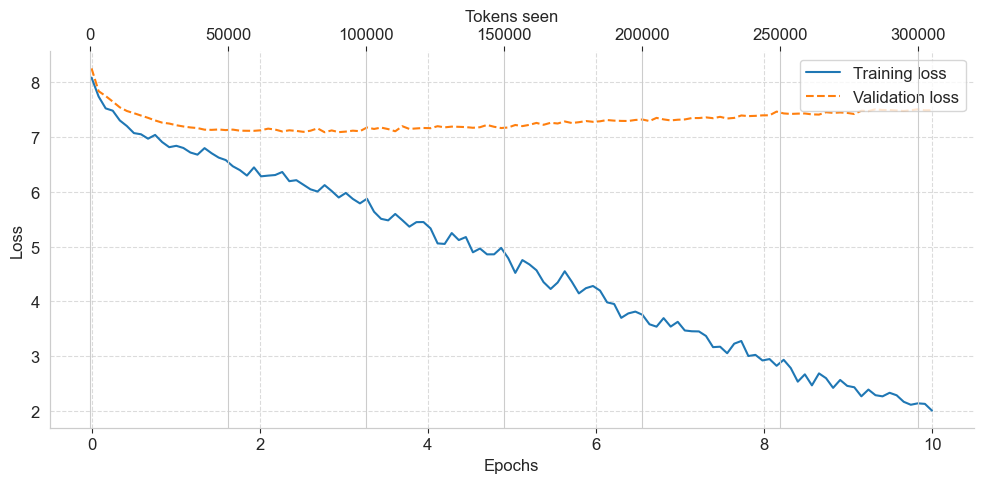

In [ ]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Use seaborn for plotting
    sns.lineplot(x=epochs_seen.numpy(), y=train_losses, ax=ax1, label="Training loss")
    sns.lineplot(x=epochs_seen.numpy(), y=val_losses, ax=ax1, label="Validation loss", 
                 linestyle="--")
    
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2 = ax1.twiny()
    # Just to establish the twin x scale, not showing this line
    ax2.plot(tokens_seen, [train_losses[0] for _ in tokens_seen], alpha=0)
    ax2.set_xlabel("Tokens seen")
    
    # Add grid and set style
    ax1.grid(True, linestyle='--', alpha=0.7)
    sns.despine(fig=fig)
    
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


# Treinando nosso Modelo

Para fins de eficiência, praticidade e organização, criei o script de treinamento fora do Jupyter Notebook. Dentro da pasta `src` no repositório do projeto, encontramos 4 arquivos que usaremos para treinar nosso modelo:

- `main.py` → Responsável por instanciar as classes necessárias e iniciar o treinamento
- `dataloader.py` → Contém a classe do Dataset e a função de criação do dataloader
- `model.py` → Contém as classes do nosso modelo
- `train_model.py` → Classe contendo o loop de treinamento

O conteúdo dos arquivos é essencialmente o mesmo que vimos e testamos no Jupyter Notebook, porém com alguns ajustes para otimizar o treinamento e evitar overfitting

## **Decaimento de Peso Diferenciado**

Na classe `TrainModel` podemos observar que estamos usando o mesmo otimizador, porém com uma diferença importante: fazemos uma distinção entre as camadas nas quais aplicaremos o decaimento de peso e aquelas nas quais não aplicaremos

```python
p_dict = {p_name: p for p_name, p in self.MODEL.named_parameters() if p.requires_grad}
weight_decay_p = [p for n, p in p_dict.items() if p.dim() >= 2]
no_weight_decay_p = [p for n, p in p_dict.items() if p.dim() < 2]

optimizer_groups = [
    {"params": weight_decay_p, "weight_decay": 0.01},
    {"params": no_weight_decay_p, "weight_decay": 0.0}
]

self.OPTIMIZER = torch.optim.AdamW(
    optimizer_groups,
    lr=self.LR,
    betas=(0.9, 0.999),
    eps=1e-8
)
```

Essa estratégia implementa a **regularização L2** (weight decay) de maneira seletiva. O processo é aplicado apenas às **matrizes bidimensionais** do modelo, que são principalmente os pesos das camadas lineares, onde a regularização é mais benéfica. Por outro lado, **vetores unidimensionais**, como *bias* e *embeddings*, são **deliberadamente excluídos** da regularização, pois estes componentes geralmente não contribuem significativamente para o overfitting.

Ao evitar a regularização excessiva de parâmetros que não precisam dela, o modelo mantém sua capacidade de aprendizado em áreas críticas enquanto previne o overfitting nas camadas mais propensas a este problema. Esta técnica tem se tornado um padrão em muitas implementações modernas de transformers.

## Schedule OneCycleLR

Um dos parâmetros mais importantes é a taxa de aprendizado, ou Learning Rate, que controla a magnitude das atualizações de peso durante o treinamento.

Uma boa prática que auxilia nossa rede a convergir é variar essa taxa ao longo do treinamento, em vez de mantê-la constante, e é para isso que servem os **schedules**

```python
self.SCHEDULER = OneCycleLR(
    self.OPTIMIZER,
    max_lr=self.LR,
    total_steps= len(self.TRAIN_LOADER) * self.NUM_EPOCHS,
    pct_start=0.1,  # 10% dos steps para warmup
    div_factor=10,  # lr_inicial = max_lr/10
    final_div_factor=100  # lr_final = lr_inicial/100
)
```

O agendador OneCycleLR, que utilizamos, orquestra o ciclo de aprendizado em 3 fases distintas:

1. **Warm-up**: Inicia o treinamento com uma taxa de aprendizado **baixa** (configuramos para dividir o learning rate por 10) e a aumenta gradualmente durante os primeiros 10% dos passos de treinamento. Essa fase inicial estabiliza o treinamento e evita oscilações bruscas.
2. **Pico de Taxa**: A taxa de aprendizado atinge seu valor **máximo** no meio do ciclo e permanece assim por um curto período. Essa fase permite uma exploração eficiente do espaço de parâmetros, buscando encontrar regiões promissoras para a solução.
3. **Annealing**: A taxa de aprendizado é gradualmente **reduzida** até um valor muito pequeno (configuramos para dividir o learning rate por 1000) ao final do treinamento. Essa fase final facilita a convergência fina, permitindo que o modelo se ajuste com precisão aos mínimos locais do espaço.

Podemos ver esse comportamento no gráfico abaixo obtido durante o treinamento do modelo

![Gráfico Loss](../assets/7-GRAFICO-LR.png)

Vemos que o Learning Rate sobe rapidamente, em seguida permanece alto por um curto período e em seguida diminui mais lentamente. Essa abordagem cíclica e dinâmica da taxa de aprendizado oferece uma série de benefícios, incluindo maior estabilidade no início do treinamento, exploração eficiente do espaço de parâmetros e convergência aprimorada na fase final do aprendizado. 

## **Clipping de Gradiente**

Implementamos o clipping de gradiente como uma técnica crucial para controlar a **explosão de gradientes**.

O **gradiente**, no contexto de redes neurais, funciona como uma bússola que indica a direção e intensidade necessárias para ajustar os parâmetros do modelo, visando reduzir a loss.

A **norma do gradiente** mensura a intensidade dessas mudanças necessárias em cada etapa do treinamento. Quando essa norma atinge valores muito **elevados**, significa que pequenas alterações nos parâmetros estão causando mudanças drásticas na função de perda. Em redes neurais profundas, isso pode desencadear um efeito cascata onde os gradientes crescem **exponencialmente** - fenômeno conhecido como **explosão de gradientes**.

Para solucionar esse desafio, o **clipping de gradiente** estabelece um limite máximo para a magnitude dos gradientes, preservando sua direção mas evitando atualizações bruscas que poderiam desestabilizar o aprendizado.

```python
torch.nn.utils.clip_grad_norm_(self.MODEL.parameters(), max_norm=1.0)
```

Dessa forma, evitamos uma possível desestabilização da rede durante o treinamento. O gráfico da norma extraído do treinamento mostra que houve momentos em que a norma ultrapassou o limiar de 1 – especialmente no início do treinamento – e nesses momentos o clipping foi fundamental para manter a estabilidade da rede.

![Gráfico Loss](../assets/7-GRAFICO-NORM.png)

## Monitoramento e Métricas

Para monitorar o progresso e desempenho do nosso modelo durante o treinamento, integramos o **Weights & Biases (wandb)** - uma plataforma moderna de experimentação para machine learning. Através dela, registramos e visualizamos em tempo real diversas métricas essenciais:

- **Loss (Treino e Validação)**: Acompanhamos a função de perda tanto no conjunto de treinamento quanto no de validação, permitindo avaliar o aprendizado do modelo e identificar possíveis casos de overfitting.
- **Perplexidade**: A métrica que vimos anteriormente que indica quão "surpreso" o modelo fica com os dados. Quanto menor a perplexidade, melhor o desempenho do modelo.
- **Diferença Treino-Validação**: Monitoramos a diferença entre as losses de treino e validação para detectar precocemente sinais de overfitting, quando o modelo começa a memorizar o conjunto de treinamento.
- **Norma do Gradiente**: Acompanhamos a magnitude dos gradientes para garantir um treinamento estável e efetivo, identificando possíveis casos de explosão ou desvanecimento de gradientes.
- **Learning Rate**: Visualizamos as mudanças na taxa de aprendizado ao longo do tempo, confirmando que o scheduler OneCycleLR está funcionando conforme esperado.

## Resultado do Treinamento

Para agilizar o processo de treinamento, optei por alugar uma máquina virtual com GPU em vez de treinar localmente o modelo. Utilizei o serviço da RunPod e instanciei uma VM com uma **RTX 2000 Ada** (16GB VRAM / 31GB RAM), utilizando-a por 3h30 para executar o script de treino, o que custou menos de $1.

Este tempo foi mais que suficiente para nosso teste e experimentação. Ao todo, nosso modelo foi treinado por mais de 4 mil passos e processou quase 33M de tokens (muito além dos 300k tokens do nosso teste no Jupyter Notebook)

![Gráfico Geral](../assets/7-GRAFICO-GERAL.png)

Com isso, conseguimos atingir uma loss de 3.5 no conjunto de validação e uma perplexidade de 34, resultados que considerei satisfatórios para nosso teste.

![Gráfico Loss](../assets/7-GRAFICO-LOSS.png)

O script salvou checkpoints durante o treinamento e com isso podemos agora recuperar o modelo e compara-lo com o modelo que treinamos anteriormente no Jupiter Notebook

In [ ]:
responses = []
for i in range(5):
    response = generate_sample(
        model=MODEL, 
        device=get_device(), 
        tokenizer=tk, 
        input_text="O Brasil é", 
        max_token=30, 
        temperature=0.4,
        top_k=40,
        top_p=0.9
    )
    responses.append(response)
print("")
for i, response in enumerate(responses):
    print(f"Resposta {i+1}: {response}")

#OUTPUT
# Resposta 1: O Brasil é e suaset se de L que parag:
# 
# 1. Tf, a S, poden. Met (2.<|eos|>
# Resposta 2: O Brasil é o dondia de 1220019.<|eos|>
# Resposta 3: O Brasil é em b�1, Mett ( de Jor, 192, e ao norte com a uma colôo
# Resposta 4: O Brasil é de Js da um St, Mos, que Seterndiap, Mos e é 11, At mais
# Resposta 5: O Brasil é e arrem em 1212010, a ar queem Batr, J com Jw e mais de

Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 24.98it/s]


Resposta 1: O Brasil é e suaset se de L que parag:


1. Tf, a S, poden. Met (2.<|eos|>
Resposta 2: O Brasil é o dondia de 1220019.<|eos|>
Resposta 3: O Brasil é em b�1, Mett ( de Jor, 192, e ao norte com a uma colôo
Resposta 4: O Brasil é de Js da um St, Mos, que Seterndiap, Mos e é 11, At mais
Resposta 5: O Brasil é e arrem em 1212010, a ar queem Batr, J com Jw e mais de


Podemos ver que nosso modelo, treinado rapidamente em 300k tokens ainda é muito semelhante ao sem treinamento, gerando textos completamente aleatórios. Vamos comparar com o desempenho do modelo que pré treinei em 33M de tokens

In [ ]:
MODEL_PT = GPTModel(
    d_vocab=tk.vocab_size(),
    d_emb=768,
    context_length=256,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=True,
).to(get_device())

state_dict = torch.load("../models/pretrain/checkpoint.pth", weights_only=False, map_location=get_device())
MODEL_PT.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
responses = []
for i in range(5):
    response = generate_sample(
        model=MODEL_PT, 
        device=get_device(), 
        tokenizer=tk, 
        input_text="O Brasil é", 
        max_token=30, 
        temperature=0.4,
        top_k=40,
        top_p=0.9
    )
    responses.append(response)
print("")
for i, response in enumerate(responses):
    print(f"Resposta {i+1}: {response}")

#OUTPUT
# Resposta 1: O Brasil é o maior país do mundo.<|eos|>
# Resposta 2: O Brasil é o maior país do mundo, com cerca de 300 milhões de habitantes.<|eos|>
# Resposta 3: O Brasil é um dos maiores jogadores de todos os tempos.<|eos|>
# Resposta 4: O Brasil é um dos maiores produtores de todos os tempos.
# 
# A Basta é um dos maiores produtores de todos os tempos, com uma ampla
# Resposta 5: O Brasil é o maior país do mundo, com uma população de 12.20.000 habitantes, com uma população de 2.

Gerando Tokens...: 100%|██████████| 30/30 [00:01<00:00, 25.06it/s]


Resposta 1: O Brasil é o maior país do mundo.<|eos|>
Resposta 2: O Brasil é o maior país do mundo, com cerca de 300 milhões de habitantes.<|eos|>
Resposta 3: O Brasil é um dos maiores jogadores de todos os tempos.<|eos|>
Resposta 4: O Brasil é um dos maiores produtores de todos os tempos.

A Basta é um dos maiores produtores de todos os tempos, com uma ampla
Resposta 5: O Brasil é o maior país do mundo, com uma população de 12.20.000 habitantes, com uma população de 2.


É possível observar uma melhora significativa. Embora as frases ainda apresentem erros evidentes e imperfeições, o modelo claramente aprendeu padrões básicos da língua portuguesa e consegue gerar estruturas mais coerentes, mesmo que nem sempre precisas. 

Vale ressaltar que estamos trabalhando com um modelo de 88 milhões de parâmetros, treinado com apenas 33 milhões de tokens. Em comparação, os modelos modernos possuem dezenas ou centenas de bilhões de parâmetros e são treinados com trilhões de tokens.

Ainda assim, é notável que nosso humilde modelo tenha conseguido aprender padrões básicos de linguagem e demonstrar capacidade generativa, mesmo que limitada.

# Conclusão

Mais uma etapa concluída na nossa jornada de aprendizado sobre LLMs!  Neste artigo, nos dedicamos a entender e implementar o treinamento de um modelo de linguagem desde a estaca zero.  Percorremos um longo caminho, desde a definição da arquitetura GPT até a organização dos dados e a configuração do processo de treinamento.  

O modelo que criamos, embora ainda distante dos modelos estado da arte (SOTA), demonstrou o potencial da arquitetura Transformer e nos proporcionou uma compreensão de como esses sistemas operam em suas entranhas. 

Para finalizar nossa série, no próximo artigo vamos dar um passo adiante e descobrir como podemos aprimorar modelos pré treinados, utilizando a técnica de *fine-tuning* para adaptá-los a tarefas bem definidas. Prepare-se para o nosso próximo e, possivelmente, último capítulo desta saga!

---

In [ ]:
# Salvando o modelo em SafeTensors para publicação no Hugging Face
from safetensors.torch import save_model
save_model(MODEL_PT, "../models/pretrain/model.safetensors")

In [ ]:
model_teste = GPTModel(
    d_vocab=tk.vocab_size(),
    d_emb=768,
    context_length=256,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=True
)

(set(), [])

Gerando Tokens...:  63%|██████▎   | 19/30 [00:01<00:00, 15.10it/s]

O Brasil é um país muito popular para os Estados Unidos e é um país muito maior e mais popular para os Estados Unidos.<|eos|>


In [ ]:
from safetensors.torch import load_model
load_model(model_teste, "../models/pretrain/model.safetensors")

phrase = "O Brasil é um país muito"
phrase = tk.encode(phrase)
phrase = torch.tensor(phrase, dtype=torch.long).unsqueeze(0)

response = model_teste.generate(
    phrase, 
    max=30, 
    temperature=0.4, 
    top_k=40, 
    top_p=0.9
)

response = tk.decode(response.squeeze().tolist())
print(response)

Gerando Tokens...:  80%|████████  | 24/30 [00:01<00:00, 17.97it/s]

O Brasil é um país muito popular para se conectar com outras pessoas, tornando-se um país mais popular para se conectar com outras pessoas.<|eos|>
